In [1]:
import numpy as np
import pickle
from astropy.io import fits
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate

paper_dir='../../effects-baryonic-structures/'

#ro=8.
#paper on MC used R0=8.5 kpc, using ro=8. as of now.
#vo=220.

Populating the interactive namespace from numpy and matplotlib


In [2]:
hdulist=fits.open('molecular_clouds/J_ApJ_834_57_table1.dat.gz.fits')
print (hdulist[1].columns)
aa=hdulist[1].data

ColDefs(
    name = 'Cloud'; format = 'I4'; disp = 'I4'; start = 1
    name = 'Ncomp'; format = 'I3'; disp = 'I3'; start = 6
    name = 'Npix'; format = 'I3'; disp = 'I3'; start = 10
    name = 'Area'; format = 'E12.6'; unit = 'deg2'; disp = 'E12.6'; start = 14
    name = 'GLON'; format = 'E13.6'; unit = 'deg'; disp = 'E13.6'; start = 27
    name = 'Sigb'; format = 'E12.6'; unit = 'deg'; disp = 'E12.6'; start = 41
    name = 'GLAT'; format = 'E13.6'; unit = 'deg'; disp = 'E13.6'; start = 54
    name = 'Sigl'; format = 'E12.6'; unit = 'deg'; disp = 'E12.6'; start = 68
    name = 'theta'; format = 'E13.6'; unit = 'deg'; disp = 'E13.6'; start = 81
    name = 'WCO'; format = 'E12.6'; unit = 'K.km/s'; disp = 'E12.6'; start = 95
    name = 'NH2'; format = 'E12.6'; unit = 'cm-2'; disp = 'E12.6'; start = 108
    name = 'Sigma'; format = 'E12.6'; unit = 'Msun/pc2'; disp = 'E12.6'; start = 121
    name = 'Vcent'; format = 'E13.6'; unit = 'km/s'; disp = 'E13.6'; start = 134
    name = 'SigV'; for

#To setup the orbits of the MCs, take (l,b,d) --> galactocentric rectangular coordinates

[R,vR,vT(,z,vz,phi)]

In [3]:
l=aa['GLON']
b=aa['GLAT']
#Near or far distance flag (0=near; 1=far) 
flag=aa['INF']
Dnear=aa['Dnear']
Dfar=aa['Dfar']
znear=aa['znear']
zfar=aa['zfar']
R_sph_gal=aa['Rgal']
Rnear=aa['Rnear']
Rfar=aa['Rfar']
Mnear=aa['Mnear']
Mfar=aa['Mfar']

#The radius of the GMCs follow $R \sim 295\rm{pc}\left(\frac{M}{10^7 \rm{M}_{\odot}}\right)^{0.45}$ which is very similar to the subhalo mass profile, but $R$ includes the entire mass of the GMC. We will model the GMCs as Plummer spheres whose 90% mass is within $3\times$ its scale radius, and use the $r_{s}(M)=100\rm{pc}\left(\frac{M}{10^7 \rm{M}_{\odot}}\right)^{0.5}$

In [4]:
ro=8.
vo=220.

def lbd_to_galcencyl(l,b,d,degree=True):
    xyz=bovy_coords.lbd_to_XYZ(l,b,d,degree=degree)
    Rphiz=bovy_coords.XYZ_to_galcencyl(xyz[:,0],xyz[:,1],xyz[:,2],Xsun=1.,Zsun=0.)
    
    return (Rphiz[:,0],Rphiz[:,1],Rphiz[:,2])

D_all=np.empty(len(l))
zfile=np.empty(len(l))
Rs_all=np.empty(len(l))
M_all=np.empty(len(l))


for ii in range(len(l)):
    if flag[ii] == 0 :
        D_all[ii]=Dnear[ii]
        zfile[ii]=znear[ii]
        Rs_all[ii]=Rnear[ii]*0.001  #convert to kpc
        M_all[ii]=Mnear[ii]
        
        
    else :
        D_all[ii]=Dfar[ii]
        zfile[ii]=zfar[ii]
        Rs_all[ii]=Rfar[ii]*0.001 #convert to kpc
        M_all[ii]=Mfar[ii]
        

def rs(M):
    return 0.1*(M/10**7.)**0.5

def Rfit(M):
    return 0.295*(M/10**7.)**0.45

#for ii in range(len(M_all)):
#    rs_all[ii]=rs(M_all[ii])


R_all,phi_all,z_all= lbd_to_galcencyl(l,b,D_all*(8.5/8.))
R_all1,phi_all1,z_all1= lbd_to_galcencyl(l,b,D_all)

#R_all/=ro
#z_all/=ro

#R_all1/=ro
#z_all1/=ro



[0.00127561 0.29691305] [[ 3.52619695e-09 -2.15230296e-07]
 [-2.15230296e-07  1.33533386e-05]]


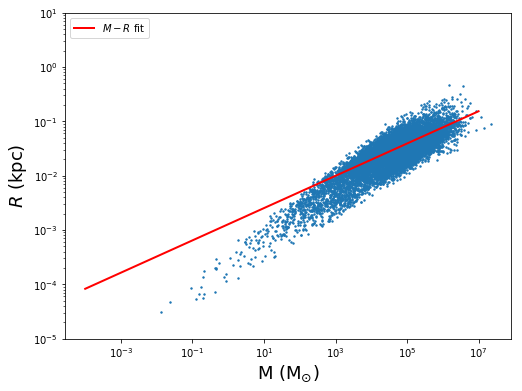

In [17]:
def func1(M,A,B):
    return A*(M)**B 


popt, pcov = curve_fit(func1, M_all, Rs_all,p0=[0.5,0.5])

print (popt,pcov)

mm=np.linspace(10**-4.,10**7.)

plt.figure(figsize=(8,6))
plt.scatter(M_all,Rs_all,s=2)
plt.plot(mm,func1(mm,popt[0],popt[1]),label=r'$M-R$ fit',c='r',lw=2)

plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-5,10)
#plt.xlim(0.001,10**8.)
plt.xlabel(r'M ($\rm{M}_{\odot}$)',fontsize=18)
plt.ylabel(r'$R$ (kpc)',fontsize=18)
plt.legend(loc='upper left')
#plt.savefig('plots/R-M.pdf')
plt.show()

In [ ]:
#Rs vs M


def rs_Hern(M):
    return 1.62*(M/10**8.)**0.5

def rs_Plum(M):
    return 1.05*(M/10**8.)**0.5

mm=np.linspace(10**-4.,10**8.)

plt.figure(figsize=(8,6))
plt.scatter(M_all,rs_all)
#plt.plot(mm,rs_Hern(mm),label='Hernquist',c='k',lw=2)
plt.plot(mm,Rfit(mm),label=r'$M-R$ fit',c='r',lw=2)
plt.plot(mm,3.*rs(mm),label=r'$3\times r_{s}$',c='k',lw=2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-5,10)
plt.xlim(0.001,10**8.)
plt.xlabel(r'M ($\rm{M}_{\odot}$)',fontsize=18)
plt.ylabel(r'$R$ (kpc)',fontsize=18)
plt.legend(loc='upper left')
#plt.savefig('plots/R-M.pdf')
plt.show()

In [ ]:
xyz=bovy_coords.lbd_to_XYZ(l,b,D_all*(8.5/8.),degree=True)
xyz1=bovy_coords.lbd_to_XYZ(l,b,D_all,degree=True)

plt.figure(figsize=(10,10))
plt.scatter(xyz[:,0],xyz[:,1],s=1)
plt.scatter(xyz1[:,0],xyz1[:,1],s=1,c='r')
plt.xlim(-15.,15.)
plt.ylim(-15.,15.)
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.show()

In [ ]:
print (max(np.abs(z_all*ro-zfile)))  #computed z and z from catalog match pretty well

print (max(rs_all))
print (max(M_all),min(M_all))

In [ ]:
#Pick only MCs which are more massive than Mmin
Mmin=10**(5)

M=[]
rs=[]
z=[]
R=[]
phi=[]

for ii in range(len(l)):
    if M_all[ii] >= Mmin :
        M.append(M_all[ii])
        rs.append(rs_all[ii])
        z.append(z_all[ii])
        phi.append(phi_all[ii])
        R.append(R_all[ii])
        
M=np.array(M)
rs=np.array(rs)
z=np.array(z)
R=np.array(R)
phi=np.array(phi)

print (len(M), len(M_all))


In [ ]:
c=0
for rr in R :
    if rr > 13./8. :
        c+=1
        
print (c)

In [ ]:
#make histogram of rs for GMCs R > R_peri_pal5
print (R*8.)
rss=[]
Ms=[]

Mexp=np.linspace(3.,9.,45)

Mbins=10**Mexp

for ii in range(len(R)):
    if R[ii]*8. > 7.34 :
        rss.append(rs[ii])
        Ms.append(M[ii])
        
plt.figure()
plt.hist(Ms,bins=Mbins,histtype='step',lw=2)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('GMC_hist_R_greater_RperiPal5.pdf')
plt.show()

In [ ]:
#assign velocities, tangential velocity = vcirc, vR=vz=0
vT=np.empty(len(M))

for ii in range(len(M)):
    vT[ii]=vcirc(MWPotential2014,R[ii])

print (vT[0:5])

vR=np.zeros(len(M))
vz=np.zeros(len(M))


In [ ]:
#initialize orbits of the MCs and integrate them back 5 Gyrs 
#as of now use MWPotential2014, because it's axisymmetric and static
#integrate back and extract (x,v) at different timpact through interpolation

t_age= np.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(vo,ro)
orbits= []

#M=M[0:10]


N=len(M)

for ii in range(N):
    
    #print ([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]])
    orbits.append(Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]]).flip()) # flip flips the velocities for backwards integration
    
    orbits[ii].integrate(t_age,MWPotential2014)
    

In [ ]:
print (M)
orbits[9].plot(d1='x',d2='y',ro=ro,vo=vo)

orbits[9].plot(ro=ro,vo=vo)

In [ ]:
orbits[1].plot('k.',d1='ra',d2='dec',ro=ro,vo=vo)

In [ ]:
import pal5_util
sdf_smooth= pal5_util.setup_pal5model()

In [ ]:
#load the saved pickle file for converting apars to obs coords
#with open('pkl_files/pal5pepper_4096sampling_MW2014_33.pkl','rb') as savefile:
#            #sdf_smooth= pickle.load(savefile,encoding='latin1')
#            sdf_pepper= pickle.load(savefile,encoding='latin1')
            
#load the saved pickle file for converting apars to obs coords
with open('../GMC/pkl_files/pal5pepper_Plummer_td7.0_128sampling_chainind0.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper_1= pickle.load(savefile,encoding='latin1')

In [ ]:
import MWPotential2014Likelihood
#import pal5_util
import pal5_util_MWfit
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0


#sdf_smooth= pal5_util.setup_pal5model()

##########setup Pal5 orbit and potential
ind=2
param_file='rperi_grid_select.dat'
paramf=np.genfromtxt(param_file,delimiter=',')  
pind=paramf[ind][0]
peri=round(paramf[ind][1],2)
print (peri)

flat_c=paramf[ind][2]
vc=paramf[ind][3]
tvo= vc*_REFV0

#indices greater than 14: subtract 1
if pind > 14 :
    pind -=1
    
pind=int(pind)   
potparams_file=np.loadtxt('pot_params.dat',delimiter=',')
potparams=list(potparams_file[pind])
   
pot= MWPotential2014Likelihood.setup_potential(potparams,flat_c,False,False,
                                                       pal5_util_MWfit._REFR0,tvo)


sdf_smooth_1= GMC_util.make_nondefault_pal5stream(ind,td=10.2)

In [ ]:
#timpact=sdf_pepper._timpact*bovy_conversion.time_in_Gyr(vo,ro)

timpact1=sdf_pepper_1._timpact

#print (timpact1)

for kk in range(1):
    print (sdf_pepper_1._sgapdfs_coordtransform[timpact1[kk]]._kick_interpolatedObsTrackXY)


In [ ]:
timpact=sdf_pepper._timpact

print (timpact)


print (len(timpact))

pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip()
pal5.integrate(t_age,MWPotential2014)



In [ ]:
t_age= np.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(vo,ro)
pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip()
pal5.integrate(t_age,MWPotential2014)
pal5.rperi()

# Plot Pal5 orbit, trailing arm and the progenitor at different timpacts

In [ ]:
ro=_REFR0

for kk in range(len(timpact1)):
    
    print (timpact1[kk])
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    x1=[]
    y1=[]
    z1=[]
    
    #a= sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedObsTrackXY
    #apar_all=sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedThetasTrack
    
    a1= sdf_pepper_1._sgapdfs_coordtransform[timpact1[kk]]._kick_interpolatedObsTrackXY
    apar_all1=sdf_pepper_1._sgapdfs_coordtransform[timpact1[kk]]._kick_interpolatedThetasTrack
    
    #lbd=bovy_coords.XYZ_to_lbd(a[:,0],a[:,1],a[:,2],degree=True)
    #radec_all=bovy_coords.lb_to_radec(lbd[:,0],lbd[:,1],degree=True) 
    #print (max(radec_all[:,0]))
    #radec_all[:,0][radec_all[:,0]>=180.]-=360.
         
    bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
    figsize(10,10)
    #pal5.plot(d1='x',d2='y')
    #scatter(np.array(a[:,0])*ro,np.array(a[:,1])*ro,c='r',s=1)
    #scatter(pal5.x(timpact[kk]),pal5.y(timpact[kk]),s=100,c='g')
    
    #at each timpact compute apar_max
    #apar_max=sdf_smooth.length(tdisrupt=sdf_pepper._tdisrupt-timpact[kk])*sdf_pepper._length_factor
    apar_max1=sdf_smooth_1.length(tdisrupt=sdf_pepper_1._tdisrupt-timpact1[kk])*sdf_pepper_1._length_factor
    
    #considering the stream until apar_max, store xyzvxvyvz 
    #for ii in range(len(apar_all)):
    #    if apar_all[ii] <= apar_max : 
    #        x.append(a[:,0][ii])
    #        y.append(a[:,1][ii])
    #        z.append(a[:,2][ii])
        
   
    for ii in range(len(apar_all1)):
        if apar_all1[ii] <= apar_max1 : 
            x1.append(a1[:,0][ii])
            y1.append(a1[:,1][ii])
            z1.append(a1[:,2][ii])
    
    #lbd1=bovy_coords.XYZ_to_lbd(np.array(x),np.array(y),np.array(z),degree=True)
    #radec=bovy_coords.lb_to_radec(lbd1[:,0],lbd1[:,1],degree=True) 
    #print (radec[:,0])
    #radec[:,0][radec[:,0]>=180.]-=360.
    
    #print (radec[:,0])
    
    
    
    #plt.scatter(np.array(x)*ro,np.array(y)*ro,c='k',s=1)
    plt.scatter(np.array(x1)*ro,np.array(y1)*ro,c='r',s=1)
    plt.xlim(-20.,20.)
    plt.ylim(-17.,17.)
    plt.show()
    
    
    #x.append(a[:,0])
    #y.append(a[:,1])
    #z.append(a[:,2])
    
    
    #apar=apar_all[apar_all < apar_max]
    #print len(apar)
    
    #print (len(a[:,0]))

In [ ]:
prog,pot,sigv,tvo=GMC_util.set_prog_potential(2)

def parse_times(times,age,ro,vo):
    if 'sampling' in times:
        nsam= int(times.split('sampling')[0])
        return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
                for ti in numpy.arange(1,nsam+1)/(nsam+1.)*age]
    return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
            for ti in times.split(',')]
            
timpacts= parse_times('8356sampling',10.2,ro=_REFR0,vo=tvo)

size= 64

tarray=[timpacts[i:i+size] for i  in range(0, len(timpacts), size)]
   
timpactn=tarray[82]

print (timpactn)

In [ ]:
def compute_min_separation(x_mc,y_mc,z_mc,apar,x_stream,y_stream,z_stream):
    '''
    given (x,y,z) of each molecular cloud, compute the minimum separation from the stream chunks
    
    input: x_mc,y_mc,z_mc of the MCs,
    x_stream,y_stream,z_stream as arrays of the stream chunks
    apar of the stream chunks, in order to output the apar at which the minimum separation from the 
    MC occured
    '''
    
    diffx=x_stream - x_mc
    diffy=y_stream - y_mc
    diffz=z_stream - z_mc
    
    diffxyz=np.c_[diffx,diffy,diffz]
    
    norm = numpy.linalg.norm(diffxyz,axis=1)
    
    #print (diffx)
    
    #print (norm)
    
    #print (len(x_stream), len(norm))
    
    min_ind=numpy.argmin(norm)
    
    min_sep= norm[min_ind]
    
    apar_min=apar[min_ind]
    
    return (min_sep,apar_min)
    
    

In [ ]:
print (sdf_pepper_1._sigMeanSign)


In [ ]:
#timpact_short=timpact[0:6]

#for each MC store min sep and apar of closest approach at each timpact
min_sep_matrix=np.empty([len(orbits),len(timpact)])
apar_matrix=np.empty([len(orbits),len(timpact)])


for kk in range(len(timpact)):
    
    apar=[]
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    
    a= sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedObsTrackXY
    apar_all=sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedThetasTrack
      
            
    #at each timpact compute apar_max
    apar_max=sdf_smooth.length(tdisrupt=sdf_pepper._tdisrupt-timpact[kk])*sdf_pepper._length_factor
    
    #considering the stream until apar_max, store xyzvxvyvz 
    for ii in range(len(apar_all)):
        if apar_all[ii] <= apar_max :
            apar.append(apar_all[ii])
            x.append(a[:,0][ii])
            y.append(a[:,1][ii])
            z.append(a[:,2][ii])
            vx.append(a[:,3][ii])
            vy.append(a[:,4][ii])
            vz.append(a[:,5][ii])
            
    x_stream=np.array(x)
    y_stream=np.array(y)
    z_stream=np.array(z)
    vx_stream=np.array(vx)
    vy_stream=np.array(vy)
    vz_stream=np.array(vz)
    apar=np.array(apar)
    
      
    #compute min_sep of each MC
    for jj in range(len(orbits)) :
        x_mc=orbits[jj].x(timpact[kk])
        y_mc=orbits[jj].y(timpact[kk])
        z_mc=orbits[jj].z(timpact[kk])
        
        min_sep,apar_min=compute_min_separation(x_mc,y_mc,z_mc,apar,x_stream,y_stream,z_stream)
        
        min_sep_matrix[jj,kk]=min_sep
        apar_matrix[jj,kk]=apar_min
        
        #print (min_sep,apar_min)


In [ ]:
#for each MC plot min separation at all timpact

ind=1090

aa=min_sep_matrix[ind]

print (5.*rs[ind]/ro,aa[aa<5.*rs[ind]/ro]) #print min_sep everytime it closer than 5r_s



plt.figure(figsize=(12,6))
plt.scatter(timpact,min_sep_matrix[ind])
plt.hlines(5.*rs[ind]/ro,-1.,150.,label=r'$5\times r_{s}$')
plt.xlabel('timpact (galpy units)')
plt.ylabel('min separation')
plt.legend(loc='upper right')
#plt.savefig('min_separation_MC{}.pdf'.format(ind))
plt.show()

In [ ]:
print (np.shape(min_sep_matrix[0]))

In [ ]:
#from the constructed matrices of min_sep and min_apar, compute the min separation for each MC for all timpact
#and the corresponding apar_min, also compute velocity of the MC at that timpact

#impactb=np.empty(len(orbits))
#impact_angle=np.empty(len(orbits))
#vx_mc=np.empty(len(orbits))
#vy_mc=np.empty(len(orbits))
#vz_mc=np.empty(len(orbits))
#timpact_at_min=np.empty(len(orbits))

impactb=[]
impact_angle=[]
vx_mc=[]
vy_mc=[]
vz_mc=[]
timpact_at_min=[]
rs_mc=[]
M_mc=[]


c=0
for ii in range(len(orbits)):
    
    bmax=5.*rs[ii]/ro
    
    if min(min_sep_matrix[ii]) <= bmax :
        c+=1
        
        min_timpact_ind=np.argmin(min_sep_matrix[ii])
        print (ii)
        impactb.append(min_sep_matrix[ii,min_timpact_ind])
        impact_angle.append(sdf_pepper._sigMeanSign*apar_matrix[ii,min_timpact_ind]) # _sigMeanSign = -/+ = trail/lead
        timpact_at_min.append(timpact[min_timpact_ind])
        rs_mc.append(rs[ii]/ro)
        M_mc.append(M[ii]/bovy_conversion.mass_in_msol(vo,ro))
        #flip velocities
        vx_mc.append(-orbits[ii].vx(timpact[min_timpact_ind]))
        vy_mc.append(-orbits[ii].vy(timpact[min_timpact_ind]))
        vz_mc.append(-orbits[ii].vz(timpact[min_timpact_ind]))

#combine vx,vy,vz to v
v_mc=np.c_[vx_mc,vy_mc,vz_mc]
print (c)

In [ ]:
#a) histogram of timpact
#b) histogram of M (and maybe compare to the full histogram of M)
#c) histogram of impactb
#d) histogram of impact angle
#e) timpact vs. impact angle

#plot histogram of min separation vs timpact

dt=timpact[1]-timpact[0]
tbin_edges=[timpact[0] - 0.5*(dt) + i*dt for i in range(len(timpact)+1)] 


plt.figure(figsize=(17,10))
plt.subplot(2,3,1)
plt.title('timpact')
plt.hist(timpact_at_min,bins=tbin_edges)

plt.subplot(2,3,2)
mbins=np.linspace(10**6.,10**7.,25)

plt.title('M')
plt.hist(np.array(M_mc)*bovy_conversion.mass_in_msol(vo,ro),bins=mbins,histtype='step',lw=2,label=r'minsep $<$ 5rs')
plt.hist(M,bins=mbins,histtype='step',lw=2,label=r'$10^{6} - 10^{7} \rm{M}_{\odot}$')
plt.legend(loc='upper right')



plt.subplot(2,3,3)
plt.title('impactb')
plt.hist(impactb,bins=30,histtype='step',lw=2)





plt.subplot(2,3,4)
plt.title('impact angle')
plt.hist(impact_angle,bins=30,histtype='step',lw=2)




plt.subplot(2,3,5)
plt.title('timpact vs impact angle')
plt.scatter(timpact_at_min,impact_angle)
plt.xlabel('timpact')
plt.ylabel('impact angle')

plt.savefig('plots/MC_impact_test_{}timpacts.pdf'.format(len(timpact)))

plt.show()






In [ ]:
import streampepperdf

sdf_pepper.set_impacts(impactb=impactb,subhalovel=v_mc,impact_angle=impact_angle,timpact=timpact_at_min,rs=rs_mc,GM=M_mc)



## combine densOmega

In [ ]:
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3,poly_norm=True):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    #print (mradec)
    mxieta= pal5_util_old.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    pp= Polynomial.fit(apars,dens,deg=3)
    outll= numpy.arange(0.25,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    
    if poly_norm:
        ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/pp(apars))
        
    else :
        ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    
    return (outll,ipdens(ipll(outll)))


def set_ranges_and_labels_dens():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    ylabel(r'$\sqrt{P_{\delta\delta}(k_{\xi})}$',fontsize=18)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.002,10.)
    xlim(1,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None


def pk_scatter(fname,N,scatter=False,zorder=1,ls='-',lw=2.):
    
    filename0=fname + '0.dat'
    dat0=np.loadtxt(filename0)
    ll=dat0[:,0][4:]
    tdata=dat0[:,1][4:]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
       
    ppy= numpy.empty((N,len(px)))
    
    ppy[0]=py
    
    for ii in range(1,N):
        filename=fname + '{}.dat'.format(ii)
        dat=np.loadtxt(filename)
        ll=dat[:,0][4:]
        tdata=dat[:,1][4:]
        ppy[ii]= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))[1].real
           
    if not scatter:
            
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])))
        
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*numpy.abs(ll[-1]-ll[0]))
                
        ppy.sort(axis=0)
        
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.023*N))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.977*N)-1)]*(ll[-1]-ll[0])))
                #numpy.sqrt(ppy[int(numpy.round(0.159*N))]*(ll[-1]-ll[0])),
                #numpy.sqrt(ppy[int(numpy.round(0.84*N)-2)]*(ll[-1]-ll[0])))
                
    
def plot_pk_scatter(filename,N,color='k',zorder=1,ls='-',
              fill=True,fill_color='k',fill_zorder=0,label=''):
    
    
    px, py= pk_scatter(fname=filename,N=N)
    
    loglog(px,py,lw=2.,color=color,zorder=zorder,ls=ls,label=label)
    
    if fill:
        plotx, dum, low, high= pk_scatter(filename,N=N,scatter=True)
    
        fill_between(plotx,low,high,color=fill_color,zorder=fill_zorder,alpha=0.5)
        #errorbar(plotx,py,yerr=[py-low,py+high],color=color,fmt='o',capsize=5.,capthick=1.,ecolor=color)
        #set_yscale('log')
        #set_xscale('log')
    legend(loc='lower right',fontsize=16)    
    return None  


def compute_Pk(filename=''):
    dat=np.loadtxt(filename)
    ll=dat[:,0][4:]
    tdata=dat[:,1][4:]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    #return 180./px/numpy.pi, py, py_err #if apars
    
    return (px,py)


       

In [ ]:
#combine densOmega files from different random rotate runs

import pal5_util_old
from scipy import ndimage, signal, interpolate
import GMC_util


#load the saved pickle file for converting apars to obs coords
with open('../GMC/pkl_files/pal5pepper_128sampling_Plummer_MW2014.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')


n_apar=175
for jj in range(42):
    
    print (jj)
    apar=np.empty(n_apar)
    dens=np.empty(n_apar)
    dens_unp=np.empty(n_apar)
    Omega=np.empty(n_apar)

    #'#apar   dens_unp   dens  omega_unp   omega'
    
    dir='../GMC/MC_densOmega/4096_on_128_Plummer_Mmin105_rand_rotate/'
    dir1='molecular_clouds/dens_combined/'

    for ii in range(n_apar):
        dat=np.loadtxt(dir + 'densOmega_4096_on_128_Plummer_Mmin105_rand_rotate{}_{}.dat'.format(jj,ii))
        apar[ii]=dat[0]
        dens_unp[ii]=dat[1]
        dens[ii]=dat[2]
        Omega[ii]=dat[4]
        
    mT= sdf_pepper.meanTrack(apar,_mO=Omega,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)

    plt.figure()
    plt.plot(mradec[:,0],mradec[:,1])
    plt.show()
        
    ll,tdata= convert_dens_to_obs(apar,dens,dens_unp,Omega,poly_deg=3)
    fo=open(dir1 + 'dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_poly3norm_{}.dat'.format(jj),'w')
    fo.write('#xi   dens/dens_smooth' + '\n')

    for ii in range(len(ll)):
        fo.write(str(ll[ii]) + '   ' + str(tdata[ii]) + '\n')

    fo.close()


In [ ]:
## Code to plot the power spectrum of the CDM Plummer case to compare power with the GMCs

with open('../GMC/pkl_files/pal5pepper_64sampling_MW2014.pkl','rb') as savefile:
                sdf_smooth= pickle.load(savefile,encoding='latin1')
                sdf_pepper= pickle.load(savefile,encoding='latin1')

import pal5_util_old as pal5_util
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(0.65,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))


bfilename= '/home/nil/Dropbox/streamgap-pepper/Baryonic_effects_on_Pal5/Pal5_CDM/'
filename = bfilename + 'Pal5_t64sampling_CDM_X10_5-9_dens_all.dat'

mOfilename= filename.replace('dens','omega')

densdata= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
Om_data= numpy.genfromtxt(mOfilename,delimiter=',',max_rows=5002)

apars= densdata[0]
dens_smooth=densdata[1]
ll=[]
densll=[]

mO=Om_data[2]

ll=convert_dens_to_obs(apars,densdata[2],dens_smooth,mO,poly_deg=3)[0]
densll=convert_dens_to_obs(apars,densdata[2],dens_smooth,mO,poly_deg=3)[1]

px,py= signal.csd(densll,densll,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
py= py.real
ppy= numpy.empty((len(densdata)-2,len(px)))
ppy[0]=py


for ii in range(len(densdata)-2):
    try :
    
        mO=Om_data[2+ii]
        dens=densdata[2+ii]
        ll=convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3)[0]
        densll=convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3)[1]
                        
        ppy[ii]= signal.csd(densll,densll,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))[1].real
    
    except ValueError :
        print (ii)
        
        
        
Ppy=numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0]))
Px=1./px

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)
 
loglog(Px,Ppy,color='k',zorder=1)
#set_ranges_and_labels_dens()
#savefig('Power_Plummer_6-9_CDM.pdf')

In [ ]:
f2='molecular_clouds/dens_combined/dens_MCMmin105_impact_Pal5_4096_on_128_Plummer_poly3norm.dat'
px,py=compute_Pk(filename=f2)


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)

plot_pk_scatter('molecular_clouds/dens_combined/rand_rotate_dens_MCMmin105_Pal5_chainind0_td7.0_5735_on_128_Plummer_poly3norm_seed',N=20,color='g',label=r'$r_{\rm{peri}} = 4.68$ kpc',fill=False)
plot_pk_scatter('molecular_clouds/dens_combined/rand_rotate_dens_MCMmin105_Pal5_chainind1_td9.6_8192_on_128_Plummer_poly3norm_seed',N=20,color='b',label=r'$r_{\rm{peri}} = 5.52$ kpc',fill=False)
plot_pk_scatter('molecular_clouds/dens_combined/rand_rotate_dens_MCMmin105_Pal5_chainind5_td10.8_8848_on_128_Plummer_poly3norm_seed',N=20,color='orange',label=r'$r_{\rm{peri}} = 6.44$ kpc',fill=False)
plot_pk_scatter('molecular_clouds/dens_combined/rand_rotate_dens_MCMmin105_Pal5_chainind3_td11.7_9585_on_128_Plummer_poly3norm_seed',N=20,color='brown',label=r'$r_{\rm{peri}} = 7.18$ kpc',fill=False)
plot_pk_scatter('molecular_clouds/dens_combined/dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_poly3norm_',N=42,color='k',label=r'$r_{\rm{peri}} = 7.34$ kpc')
plot_pk_scatter('molecular_clouds/dens_combined/rand_rotate_dens_MCMmin105_Pal5_chainind4_td6.7_5489_on_128_Plummer_poly3norm_seed',N=20,color='r',label=r'$r_{\rm{peri}} = 7.92$ kpc',fill=False)
#loglog(px,py,color='r',ls='--',zorder=1,label=r'GMC catalog')
loglog(Px,Ppy,color='cyan',lw=2,ls='--',zorder=1,label=r'CDM')
legend(loc='lower right',fontsize=15)
set_ranges_and_labels_dens()
#legend(loc='lower right',fontsize=16)
savefig('plots/power_GMC_fid_allchains_CDM.pdf')

In [ ]:
#combine densOmega files

import pal5_util_old
from scipy import ndimage, signal, interpolate
#import simulate_streampepper
import GMC_util

#sdf_smooth= GMC_util.make_nondefault_pal5stream(chain_ind=1,td=9.5)

#load the saved pickle file for converting apars to obs coords
with open('../GMC/pkl_files/pal5pepper_Plummer_td11.7_128sampling_chainind3.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

n_apar=200 
apar=np.empty(n_apar)
dens=np.empty(n_apar)
dens_unp=np.empty(n_apar)
Omega=np.empty(n_apar)

#'#apar   dens_unp   dens  omega_unp   omega'

for ii in range(n_apar):
    dat=np.loadtxt('../GMC/MC_densOmega/rand_rotate_9585_on_128_Plummer_td11.7_Mmin105_chainind3/densOmega_9585_on_128_Plummer_td11.7_chainind3_seedind28_Mmin105_{}.dat'.format(ii))
    apar[ii]=dat[0]
    dens_unp[ii]=dat[1]
    dens[ii]=dat[2]
    Omega[ii]=dat[4]
    

dir1='molecular_clouds/dens_combined/'
mT= sdf_pepper.meanTrack(apar,_mO=Omega,coord='lb')
mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)

ll,tdata= convert_dens_to_obs(apar,dens,dens_unp,Omega,poly_deg=3)
fo=open(dir1 + 'rand_rotate_dens_MCMmin105_Pal5_chainind3_td11.7_9585_on_128_Plummer_poly3norm_seed28.dat','w')
fo.write('#xi   dens/dens_smooth' + '\n')

for ii in range(len(ll)):
    fo.write(str(ll[ii]) + '   ' + str(tdata[ii]) + '\n')

fo.close()

plt.figure()
plt.plot(mradec[:,0],mradec[:,1])
plt.show()

## Plot scatter of power spectrum

In [ ]:
fname = 'molecular_clouds/dens_combined/dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_poly3norm_'
f2='molecular_clouds/dens_combined/dens_MCMmin105_impact_Pal5_4096_on_128_Plummer_poly3norm.dat'
px,py=compute_Pk(filename=f2)

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)
plot_pk_scatter(fname,42)
loglog(px,py,color='r',zorder=1,label=r'no $\phi$ rotations')
legend(loc='lower right',fontsize=16)
set_ranges_and_labels_dens()

savefig('plots/powerscatter_rand_rot_GMCMmin105_Pal5_poly3norm.pdf')

In [ ]:
aa= range(20)

#for ii in range(12,13):
for ii in aa :
    
    print (ii)
    f11='molecular_clouds/dens_combined/rand_rotate_dens_MCMmin105_Pal5_chainind5_td10.8_8848_on_128_Plummer_poly3norm_seed{}.dat'.format(ii)
    den11=np.loadtxt(f11)
    px11,py11=compute_Pk(filename=f11)
    
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(den11[:,0],den11[:,1],label='',color='k')
    
    
    plt.subplot(1,2,2)
    loglog(px11,py11,color='k',zorder=1,label=r'')
    legend(loc='lower right',fontsize=16)
    set_ranges_and_labels_dens()
    plt.show()


In [ ]:
    
plt.figure()
plt.plot(apar,dens/dens_unp)

plt.xlabel(r'$\theta_{\parallel}$')
plt.ylabel(r'density/smooth density')
plt.savefig('plots/MC_106-107Msun_dens_4096_on_128_Plummer_Mmin105_rand_rotate.pdf')
plt.show()

In [ ]:
def compute_Pk(filename=''):
    dat=np.loadtxt(filename)
    ll=dat[:,0]
    tdata=dat[:,1]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    #return 180./px/numpy.pi, py, py_err #if apars
    
    return (px,py)

#f0='dens_MC_impact_Pal5_64timpacts.dat'
#f1='dens_MC_impact_Pal5_128timpacts.dat'
f2='dens_MC_impact_Pal5_256timpacts.dat'
f3='dens_MC_impact_Pal5_512timpacts.dat'
f4='dens_MC_impact_Pal5_1024timpacts.dat'
f5='dens_MC_impact_Pal5_2048timpacts.dat'
f6='dens_MC_impact_Pal5_4096_on_2048timpacts.dat'
f7='dens_MC_impact_Pal5_4096_on_128timpacts.dat'
f8='dens_MC_impact_Pal5_4096_on_128_Plummer_timpacts.dat'
f9='dens_MCMmin105_impact_Pal5_4096_on_128_Plummer_timpacts.dat'
f10='dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_timpacts.dat'

#px0,py0=compute_Pk(filename=f0)
#px1,py1=compute_Pk(filename=f1)
px2,py2=compute_Pk(filename=f2)
px3,py3=compute_Pk(filename=f3)
px4,py4=compute_Pk(filename=f4)
px5,py5=compute_Pk(filename=f5)
px6,py6=compute_Pk(filename=f6)
px7,py7=compute_Pk(filename=f7)
px8,py8=compute_Pk(filename=f8)
px9,py9=compute_Pk(filename=f9)
px10,py10=compute_Pk(filename=f10)
    


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)

#loglog(px0,py0,color='k',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 64 timpact')
#loglog(px1,py1,color='g',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 128 timpact')
#loglog(px2,py2,color='r',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 256 timpact')
#loglog(px3,py3,color='b',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 512 timpact')
#loglog(px4,py4,color='orange',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 1024 timpact')
#loglog(px5,py5,color='pink',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 2048 timpact')
#loglog(px6,py6,color='k',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 4096 on 2048 timpact')
#loglog(px7,py7,color='g',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 4096 on 128 timpact')
loglog(px8,py8,color='r',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ Plummer 4096 on 128 timpact')
loglog(px9,py9,color='b',zorder=1,label=r'$10^{5} - 10^{7} \ \rm{M}_{\odot}$ Plummer 4096 on 128 timpact')
loglog(px10,py10,color='k',zorder=1,label=r'$10^{5} - 10^{7} \ \rm{M}_{\odot}$ rot Plummer 4096 on 128 timpact')

legend(loc='lower right',fontsize=16)
set_ranges_and_labels_dens()
savefig('plots/power_MC_Pal5.pdf')

In [ ]:
#plot densities

f0='dens_MC_impact_Pal5_64timpacts.dat'
f1='dens_MC_impact_Pal5_128timpacts.dat'
f2='dens_MC_impact_Pal5_256timpacts.dat'
f3='dens_MC_impact_Pal5_512timpacts.dat'
f4='dens_MC_impact_Pal5_1024timpacts.dat'
f5='dens_MC_impact_Pal5_2048timpacts.dat'
f6='dens_MC_impact_Pal5_4096_on_2048timpacts.dat'
f7='dens_MC_impact_Pal5_4096_on_128timpacts.dat'
f8='dens_MC_impact_Pal5_4096_on_128_Plummer_timpacts.dat'
f9='dens_MCMmin105_impact_Pal5_4096_on_128_Plummer_timpacts.dat'
f10='dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_timpacts.dat'

d0=np.loadtxt(f0)
d1=np.loadtxt(f1)
d2=np.loadtxt(f2)
d3=np.loadtxt(f3)
d4=np.loadtxt(f4)
d5=np.loadtxt(f5)
d6=np.loadtxt(f6)
d7=np.loadtxt(f7)
d8=np.loadtxt(f8)
d9=np.loadtxt(f9)
d10=np.loadtxt(f10)

plt.figure(figsize=(10,8))
#plt.plot(d0[:,0],d0[:,1],label='64',c='k')
#plt.plot(d1[:,0],d1[:,1],label='128',c='g')
#plt.plot(d2[:,0],d2[:,1],label='256',c='r')
#plt.plot(d3[:,0],d3[:,1],label='512',c='b')
#plt.plot(d4[:,0],d4[:,1],label='1024',c='orange')
#plt.plot(d5[:,0],d5[:,1],label='2048',c='pink')
#plt.plot(d6[:,0],d6[:,1],label='4096-on-2048',c='k')
#plt.plot(d7[:,0],d7[:,1],label='4096-on-128',c='g')
plt.plot(d8[:,0],d8[:,1],label='4096-on-128 Plummer',c='r')
plt.plot(d9[:,0],d9[:,1],label=r'4096-on-128 Plummer Mmin $10^{5} \rm{M}_{\odot}$',c='k')
plt.plot(d10[:,0],d10[:,1],label=r'4096-on-128 rand-rot Plummer Mmin $10^{5} \rm{M}_{\odot}$',c='b')

plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'dens/dens-smooth')
plt.legend(loc='lower left')
plt.savefig('plots/dens_compare_MC.pdf')
plt.show()





In [ ]:
def compute_ndenxi(xi,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3,plot=True,fname=''):
    N=len(xi)
    print (N)
    minxi = minxi
    maxxi= maxxi
    bw= bw

    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    nden=np.histogram(xi,xibin_edge,density=True)[0]
    Ndn=np.histogram(xi,xibin_edge)[0]
    print (np.sum(Ndn))
    shot_noise=numpy.sqrt(Ndn)
    err=shot_noise/(N*bw)
    
    pp= Polynomial.fit(midxi,Ndn,deg=polydeg,w=1/err)
    nden=Ndn/pp(np.array(midxi))

In [ ]:
import pal5_util
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial
#import GMC_util

   
apar=np.empty(175)
dens=np.empty(175)
dens_unp=np.empty(175)
Omega=np.empty(175)

#'#apar   dens_unp   dens  omega_unp   omega'

for ii in range(175):
    dat=np.loadtxt('../GMC/MC_densOmega/4096_on_128_Plummer_Mmin105/densOmega_4096_on_128_Plummer_Mmin105_{}.dat'.format(ii))
    apar[ii]=dat[0]
    dens_unp[ii]=dat[1]
    dens[ii]=dat[2]
    Omega[ii]=dat[4]
    
pp= Polynomial.fit(apar,dens,deg=3)
#nden=Ndn/pp(np.array(midxi))    
plt.figure()
plt.plot(apar,dens/pp(apar))
plt.show()

### plot M impact histogram

In [ ]:
import pal5_util_old
from scipy import ndimage, signal, interpolate
import GMC_util

#../GMC/set_impact_pkl/Pal5_4096_on_128impact_Plummer_Mmin105_MC_rand_rotate_
def Mimpacts(sdfname,N=42):
    
    vo=220.
    ro=8.

    MM_gmc=[]

    impacts=0
    for ii in range(N):
        print (ii)
        #load the saved pickle file for converting apars to obs coords
        with open(sdfname + '_{}.pkl'.format(ii),'rb') as savefile:
                    #sdf_smooth= pickle.load(savefile,encoding='latin1')
                    sdf_pepper= pickle.load(savefile,encoding='latin1')
                    GMs=sdf_pepper._GM*bovy_conversion.mass_in_msol(vo,ro)
                    impacts += len(GMs)

                    for mm in GMs :
                        MM_gmc.append(mm)
                        
    print (impacts, len(MM_gmc))
    return (MM_gmc)



In [ ]:
fid_GMC= Mimpacts('../GMC/set_impact_pkl/Pal5_4096_on_128impact_Plummer_Mmin105_MC_rand_rotate')

In [ ]:
Mind0=np.loadtxt('impact_mass_chainind0.dat')  # 4.68 kpc
Mind1=np.loadtxt('impact_mass_chainind1.dat')  # 5.52 kpc 
Mind5=np.loadtxt('impact_mass_chainind5.dat')  # 6.44 kpc
Mind3=np.loadtxt('impact_mass_chainind3.dat')  # 7.18 kpc
Mind4=np.loadtxt('impact_mass_chainind4.dat')  # 7.92 kpc

print (len(Mind0)+len(Mind1)+len(Mind3)+len(Mind4)+len(Mind5))


In [ ]:
vo=220.
ro=8.

MM_cdm=[]
ll=0
for ii in range(499):
    
    print (ii)
    
    dat=np.loadtxt('Pal5_CDM/Pal5_subhalo_mass_{}.dat'.format(ii))
    n1=int(dat[0])
    n2=int(dat[n1+1])
    mm1=dat[1:n1+1]
    mm2=dat[n1+2:]
    ll+=len(mm1)+len(mm2)
    print (n1,n2)

    for m1 in mm1  :
        MM_cdm.append(m1*bovy_conversion.mass_in_msol(vo,ro))

    for m2 in mm2 :
        MM_cdm.append(m2*bovy_conversion.mass_in_msol(vo,ro))
            
     
        
print (len(MM_cdm),ll)

In [ ]:
Mexp=np.linspace(5.,9.,25)
print (len(MM_cdm))
Mbins=10**Mexp

Mall = np.concatenate((Mind0,Mind1,Mind3,Mind4,Mind5))

In [ ]:
Mavg=np.zeros(24)
Mavg+=np.histogram(Mind0,Mbins)[0]
Mavg+=np.histogram(Mind1,Mbins)[0]
Mavg+=np.histogram(Mind3,Mbins)[0]
Mavg+=np.histogram(Mind4,Mbins)[0]
Mavg+=np.histogram(Mind5,Mbins)[0]

Mavg/=5.

In [ ]:
print (Mavg)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)

#hist(Mind0,bins=Mbins,histtype='step',lw=2,color='g',label=r'$r_{\rm{peri}} = 4.68$ kpc')
#hist(Mind1,bins=Mbins,histtype='step',lw=2,color='b',label=r'$r_{\rm{peri}} = 5.52$ kpc')
#hist(Mind5,bins=Mbins,histtype='step',lw=2,color='orange',label=r'$r_{\rm{peri}} =6.44$ kpc')
#hist(Mind3,bins=Mbins,histtype='step',lw=2,color='brown',label=r'$r_{\rm{peri}} =7.18$ kpc')
#hist(Mind4,bins=Mbins,histtype='step',lw=2,color='r',label=r'$r_{\rm{peri}} =7.92$ kpc')

hist(Mall,bins=Mbins,weights=(1./(21.*5.))*np.ones(len(Mall)),histtype='step',lw=2,color='r',label='Mean')
hist(fid_GMC,bins=Mbins,weights=(1./(42.))*np.ones(len(fid_GMC)),histtype='step',lw=2,color='b',ls='--',label=r'$r_{\rm{peri}} =7.34$ kpc')

hist(MM_cdm,bins=Mbins,weights=(1./(996.))*np.ones(len(MM_cdm)),histtype='step',lw=2,color='k',ls='--',label='CDM')
xlabel(r'M ($\rm{M}_{\odot}$)',fontsize=16)
ylabel(r'$N$',fontsize=16)
xscale('log')
legend(loc='upper right',fontsize=16)
savefig('plots/GMC_CDM_impactM_hist.pdf',bbox_inches='tight')

In [ ]:
Mexp=np.linspace(5.,9.,15)

Mbins=10**Mexp

plt.figure()
plt.hist(MM_cdm,bins=Mbins,histtype='step',lw=1,color='k')
plt.xscale('log')
plt.savefig('CDM_Plummer_6-9_impactM_hist.pdf')
plt.show()

In [ ]:
import seaborn as sns
import pal5_util_old
from scipy import ndimage, signal, interpolate
import glob


with open('../GMC/pkl_files/pal5pepper_64sampling_Plummer_MW2014.pkl','rb') as savefile:
                #sdf_smooth= pickle.load(savefile,encoding='latin1')
                sdf_pepper= pickle.load(savefile,encoding='latin1')


def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util_old.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    #print (mxieta[:,0])
    outll= numpy.arange(minxi,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))


def read_data(filename):
    data1= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
    # Search for batches
    batchfilenames= glob.glob(filename.replace('.dat','.*.dat'))
    for bfilename in batchfilenames:
        try:
            datab= numpy.genfromtxt(bfilename,delimiter=',')
        except: continue
        data1= numpy.vstack((data1,datab[2:]))
    return data1
def read_dens(filename,indx=None,rand=False,poly_deg=3):
    densdata= read_data(filename)
    mOfilename= filename.replace('dens','omega')
    mOdata= read_data(mOfilename)
    apars= densdata[0]
    nsim= len(densdata)-2 # first two are apar and smooth
    ll,tdata1= convert_dens_to_obs(apars,densdata[2],densdata[1],
                                   mOdata[2],poly_deg=poly_deg)
    if not indx is None:
        return convert_dens_to_obs(apars,densdata[2+indx],densdata[1],
                                   mOdata[2+indx])
    if rand:
        rindx= int(numpy.floor(numpy.random.uniform()*nsim))
        print (rindx)
        return convert_dens_to_obs(apars,densdata[2+rindx],densdata[1],
                                   mOdata[2+rindx])
    out= numpy.zeros((nsim,len(tdata1)))
    for ii in range(nsim):
        ll, tdata1= convert_dens_to_obs(apars,densdata[2+ii],densdata[1],
                                        mOdata[2+ii])
        out[ii]= tdata1
    return (ll,out)

def median_csd(filename,filename2=None,scatter=False,
              coord1=1,coord2=1,
              err1=None,err2=None,
              poly_deg=3):
    # Compute the median CSD, if filename2 is not None, compute cross
    data1= read_data(filename)
    if filename2 is None:
        data2= data1
    else:
        data2= read_data(filename2)
    if coord1 == 'dens':
        mOfilename= filename.replace('dens','omega')
        mOdata1= read_data(mOfilename)
    if coord2 == 'dens':
        if filename2 is None:
            mOdata2= mOdata1
        else:
            mOfilename2= filename2.replace('dens','omega')
            mOdata2= read_data(mOfilename2)
    apars= data1[0]
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print ("WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename))
    if coord1 == 'dens':
        ll,tdata1= convert_dens_to_obs(apars,data1[2],data1[1],mOdata1[2],poly_deg=poly_deg)
    else:
        ll,tdata1= convert_track_to_obs(apars,data1[2],coord1)
    if coord2 == 'dens':
        ll,tdata2= convert_dens_to_obs(apars,data2[2],data2[1],mOdata2[2],poly_deg=poly_deg)
    else:
        ll,tdata2= convert_track_to_obs(apars,data2[2],coord2)
    px= signal.csd(tdata1,tdata2,fs=1./(ll[1]-ll[0]),scaling=scaling,nperseg=len(ll))[0]
    ppy= numpy.empty((nsim,len(px)))
    ppy_err= numpy.empty((nsim,len(px)))
    for ii in range(37,nsim):
        
                # convert
                if coord1 == 'dens':
                    ll,tdata1= convert_dens_to_obs(apars,data1[2+ii],data1[1],mOdata1[2+ii],poly_deg=poly_deg)
                else:
                    ll,tdata1= convert_track_to_obs(apars,data1[2+ii],coord1)
                if numpy.any(data1[2+ii] != data2[2+ii]):
                    if coord2 == 'dens':
                        ll,tdata2= convert_dens_to_obs(apars,data2[2+ii],data2[1],mOdata2[2+ii],poly_deg=poly_deg)
                    else:
                        ll,tdata2= convert_track_to_obs(apars,data2[2+ii],coord2)
                    ppy[ii]= numpy.absolute(signal.csd(tdata1,tdata2,
                                                       fs=1./(ll[1]-ll[0]),scaling=scaling,
                                                       nperseg=len(ll))[1])
                else:
                    ppy[ii]= signal.csd(tdata1,tdata1,
                                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                                        nperseg=len(ll))[1].real
                # Same for errors
                if not err1 is None:
                    tmock1= err1*numpy.random.normal(size=len(ll))
                    if numpy.any(data1[2+ii] != data2[2+ii]):
                        tmock2= err2*numpy.random.normal(size=len(ll))
                        ppy_err[ii]= numpy.absolute(signal.csd(tmock1,tmock2,
                                                               fs=1./(ll[1]-ll[0]),scaling=scaling,
                                                               nperseg=len(ll))[1])
                    else:
                        ppy_err[ii]= signal.csd(tmock1,tmock1,
                                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                                nperseg=len(ll))[1].real
                # Following is the correct scaling in the sense that random noise gives same CSD no matter how long the stream
                if not scatter:
                    return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])),
                            numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))
                else:
                    out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0]))
                    ppy.sort(axis=0)
                    return (1./px,out,
                            numpy.sqrt(ppy[int(numpy.round(0.25*nsim))]*(ll[-1]-ll[0])),
                            numpy.sqrt(ppy[int(numpy.round(0.75*nsim))]*(ll[-1]-ll[0])),
                            numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))
            
        

    
    
def plot_dens(filename,poly_deg=3,color=sns.color_palette()[0],zorder=1,ls='-',
              fill=False,fill_color='0.65',fill_zorder=0,
              err_color=sns.color_palette()[2],err_zorder=0,
              err=None,scale=1.,add_err=0.):
    px, py, py_err= median_csd(filename,coord1='dens',coord2='dens',
                               err1=err,poly_deg=poly_deg)
    py= numpy.sqrt(py**2.+add_err**2.)
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,
                                               coord1='dens',coord2='dens',
                                               poly_deg=poly_deg)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None


def plot_dens(filename,poly_deg=3,color=sns.color_palette()[0],zorder=1,ls='-',
              fill=False,fill_color='0.65',fill_zorder=0,
              err_color=sns.color_palette()[2],err_zorder=0,
              err=None,scale=1.,add_err=0.):
    px, py, py_err= median_csd(filename,coord1='dens',coord2='dens',
                               err1=err,poly_deg=poly_deg)
    py= numpy.sqrt(py**2.+add_err**2.)
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,
                                               coord1='dens',coord2='dens',
                                               poly_deg=poly_deg)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def plot_all_track(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                   fill=False,fill_color='0.65',fill_zorder=0,
                   err_color=sns.color_palette()[2],err_zorder=0,
                   errs=[None,None,None],
                   scale=1.):
    subplot(1,3,1)
    px, py, py_err= median_csd(filename,coord1=1,err1=errs[0])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=1)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,2)
    px, py, py_err= median_csd(filename,coord1=2,err1=errs[1])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[1] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=2)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,3)
    px, py, py_err= median_csd(filename,coord1=3,err1=errs[2])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[2] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=3)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def plot_all_track_dens(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                        fill=False,fill_color='0.65',fill_zorder=0,
                        err_color=sns.color_palette()[2],err_zorder=0,
                        err1=None,err2s=[None,None,None],
                        scale=1.):
    subplot(1,3,1)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=1,err1=err1,err2=err2s[0])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[0] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=1)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,2)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=2,err1=err1,err2=err2s[1])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[1] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=2)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,3)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=3,err1=err1,err2=err2s[2])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[2] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=3)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.01,10.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None
def set_ranges_and_labels():
    subplot(1,3,1)
    bovy_plot.bovy_text(r'$\sqrt{\eta\eta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,3,2)
    bovy_plot.bovy_text(r'$\sqrt{DD}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,3,3)
    bovy_plot.bovy_text(r'$\sqrt{V_{\mathrm{los}} V_{\mathrm{los}}}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def set_ranges_and_labels_cross():
    subplot(1,3,1)
    bovy_plot.bovy_text(r'$\sqrt{|\delta b|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,3,2)
    bovy_plot.bovy_text(r'$\sqrt{|\delta D|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,3,3)
    bovy_plot.bovy_text(r'$\sqrt{|\delta V_{\mathrm{los}}|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def color_from_colormap(val,cmap,cmin,cmax):
    return cmap((val-cmin)/(cmax-cmin))
def add_colorbar_dens(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None
def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

In [ ]:
bfilename= '/home/nil/Dropbox/streamgap-pepper/Baryonic_effects_on_Pal5/Pal5_CDM_6-9_Plummer/'

save_figures=False
minxi= 0.65
poly_deg= 3
scaling='spectrum'
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(11/3.,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.15,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
    
try:
    
    plot_dens(bfilename+'Pal5_t64sampling_CDM_Plummer_rsfac0p195_X25p64_6-9_dens_all.dat',
              poly_deg=poly_deg,
              color='k',zorder=2,ls='-',fill=False)

    set_ranges_and_labels_dens()
    
except ValueError:
    print (nsim)

    
    
#savefig('Pal5_CDM_Plummer_rsfac0p195_X25p64_t64sampling_X10_5-9.pdf')

In [ ]:
#combine all dens and omega files into one
import glob
import csv

bfilename= '/home/nil/Dropbox/streamgap-pepper/Baryonic_effects_on_Pal5/Pal5_CDM_6-9_Plummer/'
dens_filenames= glob.glob(bfilename+'dens/'+ '*.dat')
omega_filenames= glob.glob(bfilename + 'omega/' + '*.dat')

fall_dens='Pal5_t64sampling_CDM_Plummer_rsfac0p195_X25p64_6-9_dens_all.dat'
fall_omega=fall_dens.replace('dens','omega')
csvdensall=open(bfilename + fall_dens,'w')
csvomegaall=open(bfilename + fall_omega,'w')



dens_filename0='pal5_t64sampling_cdm_Plummer_rsfac0p195_X25p64_6-9_dens_0.dat'
omega_filename0= dens_filename0.replace('dens','omega')

dens_a= np.genfromtxt(bfilename+'dens/' + dens_filename0,delimiter=',',max_rows=5002)
omega_a=np.genfromtxt(bfilename+'omega/' + omega_filename0,delimiter=',',max_rows=5002)

apars=dens_a[0]
dens_unp=dens_a[1]
omega_unp=omega_a[1]

denswriterall= csv.writer(csvdensall,delimiter=',')
omegawriterall= csv.writer(csvomegaall,delimiter=',')
denswriterall.writerow([a for a in apars])
omegawriterall.writerow([a for a in apars])
denswriterall.writerow([d for d in dens_unp])
omegawriterall.writerow([o for o in omega_unp])

for ii in range(len(dens_filenames)):
    #print allfilenames[ii]
    dens_fname=dens_filenames[ii]
    omega_fname= dens_fname.replace('dens','omega')
    
    dens= np.genfromtxt(dens_fname,delimiter=',',max_rows=5002)
    omega=np.genfromtxt(omega_fname,delimiter=',',max_rows=5002)
    
    for i in range(2,len(dens)):
        denswriterall.writerow([dall for dall in dens[i]])
        omegawriterall.writerow([oall for oall in omega[i]])
        
csvdensall.close()  
csvomegaall.close()

In [ ]:
dd=np.loadtxt('molecular_clouds/dens_combined/dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_poly3norm_0.dat')
dd1=np.loadtxt('molecular_clouds/dens_combined/dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_poly3norm_10.dat')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
fig, ax = subplots(nrows=4, ncols=1, figsize=(8,6))

fig.text(0.05, 0.5, r'$\rm{normalized \ density}$', fontsize=18, va='center', rotation='vertical')

subplot(2,1,1)
plot(dd[:,0][4:],dd[:,1][4:],c='k')
xticks(())

subplot(2,1,2)
plot(dd1[:,0][4:],dd1[:,1][4:],c='k')
xlabel(r'$\xi\,(\mathrm{degree})$',fontsize=18)
subplots_adjust(hspace=0.0)
savefig('plots/GMC_dens_cont.pdf')



In [ ]:
print 